<a href="https://colab.research.google.com/github/karolinakuligowska/TMSMM_codes/blob/main/TMSMM_class5_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Clustering of press releases

combined.json: each row represents one press release

* id: Press release number (some are missing)
* title: Release title
* contents: Release text
* date: Posted date
* topics: Array of topic tags (if any provided)
* components: Array of agencies & departments (if any provided)

Steps:
1. Load press release data
2. Convert text to TF-IDF vectors
3. Find an optimal number of clusters
4. Apply K-means clustering
5. Visualize results (PCA + t-SNE)
6. Show top keywords per cluster

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

In [2]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud

**1. LOAD THE DATA**

In [3]:
# Each row = one press release
data = pd.read_json('combined.json', lines=True)
data.head()

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


**2. TF-IDF VECTORIZATION**

In [4]:
tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    max_features=8000,
    stop_words='english'
)

text = tfidf.fit_transform(data.contents)
print(f"TF-IDF matrix shape: {text.shape}")

TF-IDF matrix shape: (13087, 8000)


**3. FIND OPTIMAL NUMBER OF CLUSTERS (ELBOW METHOD)**

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


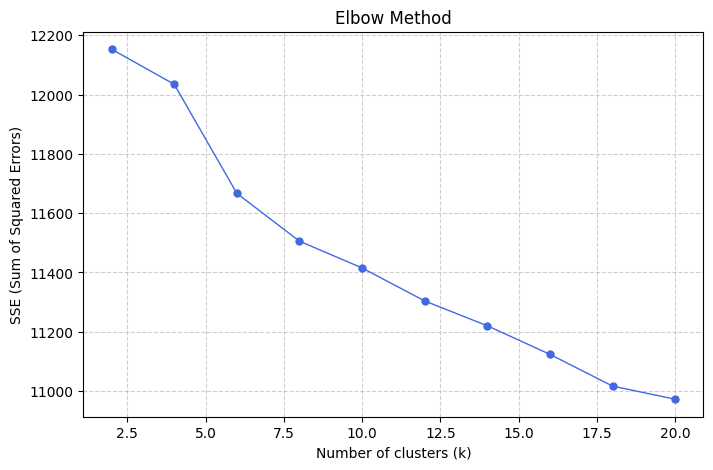

In [5]:
def find_optimal_clusters(data, max_k):
    sse = []
    ks = range(2, max_k + 1, 2)
    for k in ks:
        model = MiniBatchKMeans(n_clusters=k, random_state=42)
        model.fit(data)
        sse.append(model.inertia_)
        print(f"Fit {k} clusters")

    plt.figure(figsize=(8, 5))
    plt.plot(ks, sse, marker='o', color='royalblue', linewidth=1, markersize=5)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.title('Elbow Method')
    plt.grid(True, linestyle='--', alpha=0.6)  # Add light dashed grid
    plt.show()

find_optimal_clusters(text, 20)

**4. APPLY K-MEANS CLUSTERING**

In [6]:
k = 6  # set based on elbow plot
clusters = MiniBatchKMeans(n_clusters=k, random_state=42).fit_predict(text)


**5. VISUALIZE CLUSTERS (PCA + t-SNE)**

In [7]:
# PCA is better at capturing global structure of the data
# TSNE is better at capturing relations between neighbors
# sample from 3,000 documents and perform a PCA 50 dimension reduction on the data
# next we show a scatterplot further sampling the sample down to 300 pts

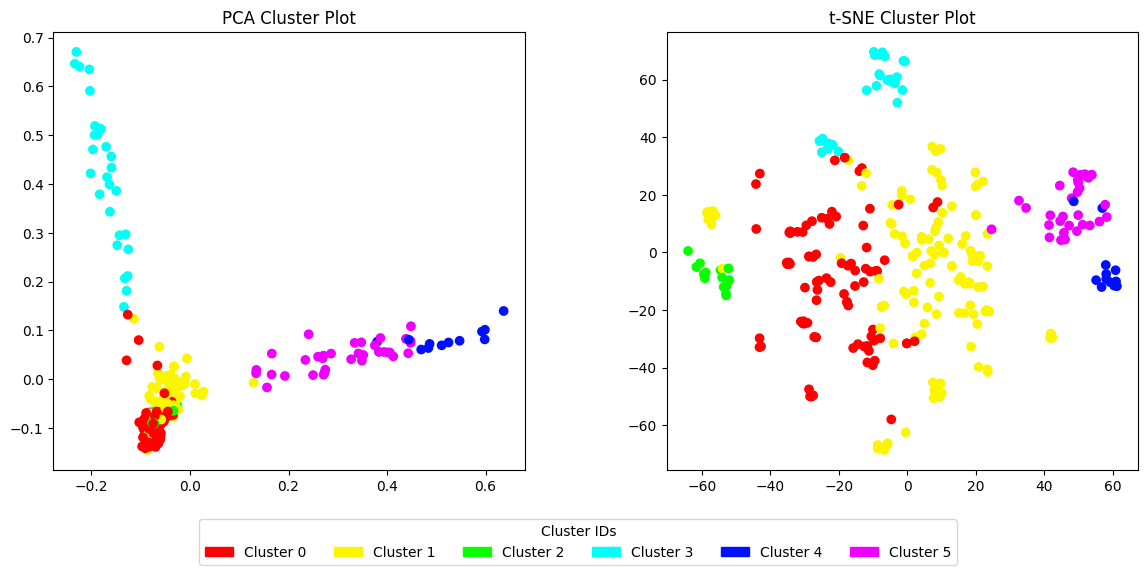

In [9]:
def plot_tsne_pca(data, labels):
    # Sample up to 3000 points for visualization
    n_samples = min(3000, data.shape[0])
    idx = np.random.choice(data.shape[0], size=n_samples, replace=False)

    X = data[idx].toarray() if hasattr(data, "toarray") else np.asarray(data[idx])
    pca = PCA(n_components=2).fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(PCA(n_components=50).fit_transform(X))

    # Random subset for clarity
    sub_idx = np.random.choice(pca.shape[0], size=min(300, pca.shape[0]), replace=False)
    label_subset = np.array(labels)[idx][sub_idx]

    # Assign colors
    unique_labels = np.unique(labels)
    label_to_color = {l: cm.hsv(i / len(unique_labels)) for i, l in enumerate(unique_labels)}
    colors = [label_to_color[l] for l in label_subset]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].scatter(pca[sub_idx, 0], pca[sub_idx, 1], c=colors)
    ax[0].set_title("PCA Cluster Plot")
    ax[1].scatter(tsne[sub_idx, 0], tsne[sub_idx, 1], c=colors)
    ax[1].set_title("t-SNE Cluster Plot")

    # Add legend below the plots
    legend = [mpatches.Patch(color=c, label=f"Cluster {l}") for l, c in label_to_color.items()]
    fig.legend(handles=legend, loc='lower center', ncol=len(unique_labels), title="Cluster IDs",
               bbox_to_anchor=(0.5, -0.02))  # Place legend below both plots

    plt.subplots_adjust(bottom=0.15, wspace=0.3)  # Add space for legend and between plots
    plt.show()

plot_tsne_pca(text, clusters)

**6. SHOW TOP KEYWORDS PER CLUSTER**

In [10]:
# top keywords based on their TFIDF score to see if we can spot any trends

def get_top_keywords(data, clusters, vectorizer, n_terms=10):
    feature_names = vectorizer.get_feature_names_out()
    df = pd.DataFrame(data.toarray()).groupby(clusters).mean()

    for cluster, row in df.iterrows():
        top_terms = np.argsort(row)[-n_terms:]
        print(f"\nCluster {cluster}:")
        print(", ".join([feature_names[i] for i in top_terms]))

get_top_keywords(text, clusters, tfidf)



Cluster 0:
act, ada, settlement, attorney, discrimination, housing, justice, civil, department, rights

Cluster 1:
office, department, division, fraud, guilty, fbi, indictment, district, criminal, attorney

Cluster 2:
emissions, environment, settlement, pollution, oil, air, clean, water, environmental, epa

Cluster 3:
patients, medical, oig, claims, services, hhs, fraud, care, health, medicare

Cluster 4:
preparing, prepared, return, irs, injunction, income, complaint, customers, returns, tax

Cluster 5:
division, accounts, bank, taxes, attorney, false, returns, income, irs, tax


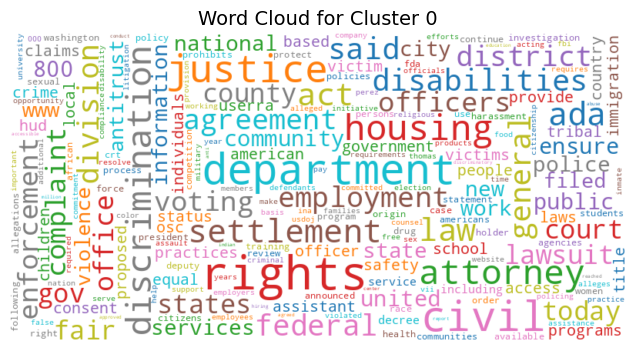

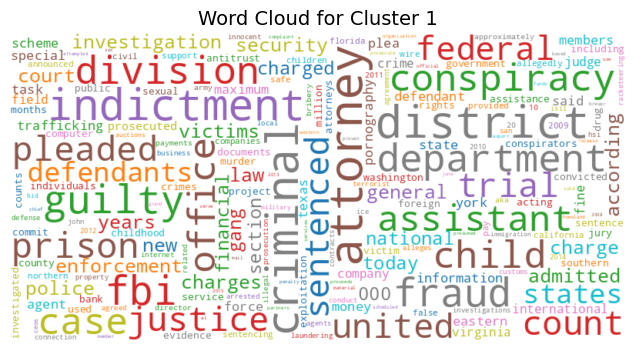

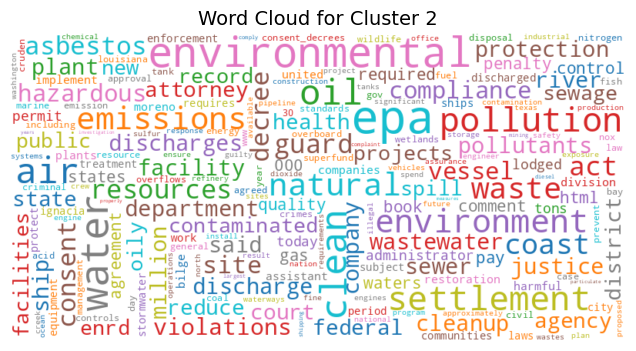

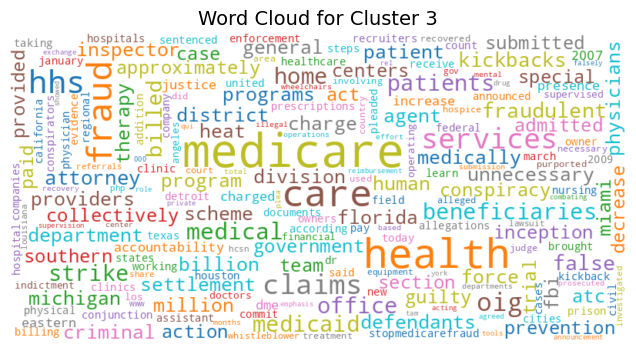

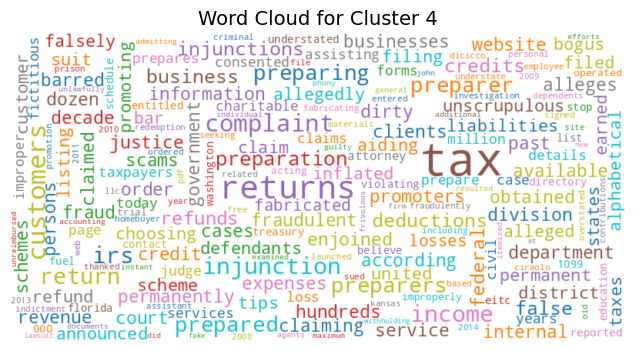

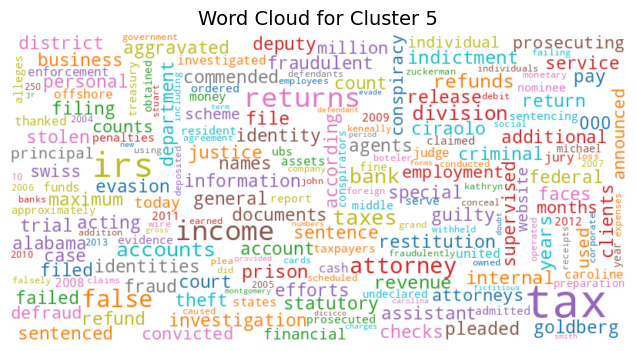

In [11]:
# each cluster visualize by wordcloud

def plot_wordcloud(data, clusters, vectorizer, cluster_id):
    """
    Plot a word cloud for a given cluster based on average TF-IDF scores.
    """
    # Always start a fresh figure
    plt.close('all')
    plt.figure(figsize=(8, 4))

    feature_names = vectorizer.get_feature_names_out()
    df = pd.DataFrame(data.toarray()).groupby(clusters).mean()

    # Create dictionary: word → average TF-IDF weight
    freqs = {feature_names[i]: v for i, v in enumerate(df.loc[cluster_id])}

    # Generate word cloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='tab10',
        min_font_size=6,
        max_font_size=60,
        prefer_horizontal=0.9
    ).generate_from_frequencies(freqs)

    # Plot
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_id}", fontsize=14)
    plt.show()

# Wordclouds for each cluster
for cluster_id in np.unique(clusters):
    plot_wordcloud(text, clusters, tfidf, cluster_id)